In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 2.5MB/s 
     |████████████████████████████████| 1.0MB 13.3MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 358kB 13.4MB/s 
     |████████████████████████████████| 92kB 6.9MB/s 
     |████████████████████████████████| 40kB 4.8MB/s 
     |████████████████████████████████| 40kB 5.4MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 2.6MB 18.1MB/s 
Mounted at /content/gdrive


In [ ]:
import fastcore
import fastai
print(f'fastcore version {fastcore.__version__} installed.')
print(f'fastai version {fastai.__version__} installed.')

fastcore version 1.0.15 installed.
fastai version 2.0.13 installed.


In [ ]:
from nbdev.showdoc import *
from fastai.vision.all import *

Let's download Imagenette dataset.

In [ ]:
path = untar_data(URLs.IMAGENETTE_320)
path.ls()

(#2) [Path('/root/.fastai/data/imagenette2-320/train'),Path('/root/.fastai/data/imagenette2-320/val')]

In [ ]:
doc(untar_data)

Create a label dictionary to label the target variables

In [ ]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [ ]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=label_func,
                   splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                   item_tfms=RandomResizedCrop(224, min_scale=0.35),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])

In [ ]:
# Returns the per channel mean & standard deviation used to normalize the image inputs.
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
# Return a list of data augumentation tranformation applied.
aug_transforms()

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

In [ ]:
## Use .summary() method as below to troubleshoot issues in dataloaders creation.Example
dblock.summary(path)

Setting-up type transforms pipelines
Found 13394 items
2 datasets of sizes 9469,3925
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/imagenette2-320/train/n03425413/n03425413_13353.JPEG
    applying PILBase.create gives
      PILImage mode=RGB size=426x320
  Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/imagenette2-320/train/n03425413/n03425413_13353.JPEG
    applying label_func gives
      gas pump
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=426x320, TensorCategory(6))


Setting up after_item: Pipeline: RandomResizedCrop -- {'size': (224, 224), 'min_scale': 0.35, 'ratio': (0.75, 1.3333333333333333), 'resamples': (2, 0), 'val_xtra': 0.1

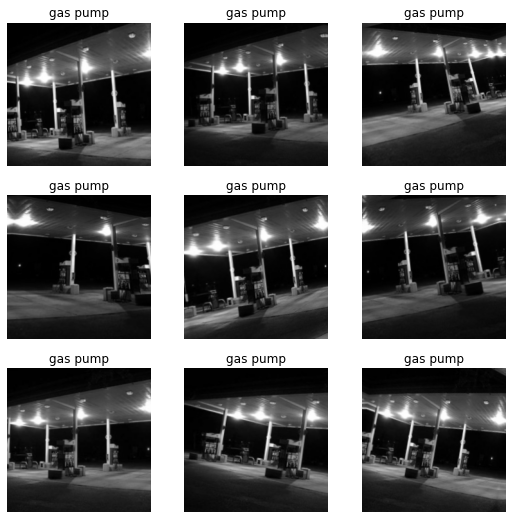

In [ ]:
dls = dblock.dataloaders(path)
dls.show_batch(unique=True)

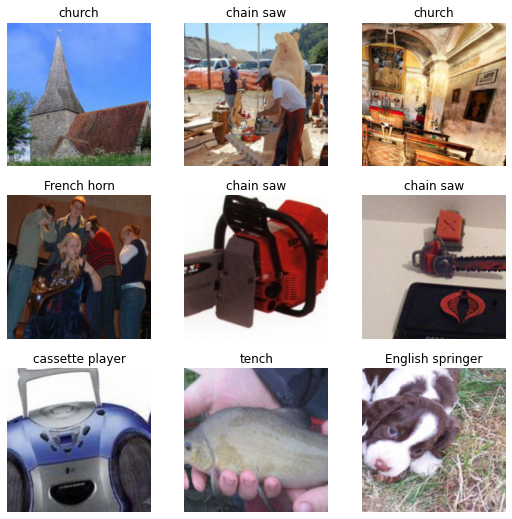

In [ ]:
dls.show_batch()

Let's get one batch of data & check

In [ ]:
xb, yb = dls.one_batch()
print(f'Input shape: {xb.shape}, target shape: {yb.shape}.')

Input shape: torch.Size([64, 3, 224, 224]), target shape: torch.Size([64]).


In [ ]:
doc(xresnet34)

Let's create a learner 

In [ ]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy)

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.0005754399462603033)

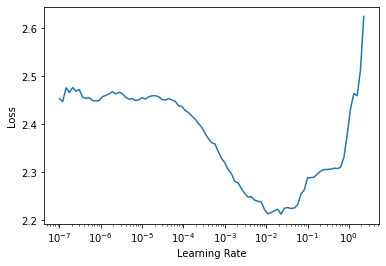

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.800560,1.649846,0.445605,04:00
1,1.384934,1.347530,0.562548,03:59
2,1.163640,1.397058,0.571465,04:00
3,1.000005,0.989200,0.687898,04:00
4,0.858684,0.968617,0.699618,04:00
5,0.765803,0.900853,0.710573,04:00
6,0.687778,0.754197,0.760255,04:00
7,0.593335,0.754725,0.770191,04:00
8,0.514813,0.601602,0.801783,04:00
9,0.479053,0.617310,0.800764,04:00


In [ ]:
learn.summary()

XResNet (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 112 x 112  864        True      
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 32 x 112 x 112  9,216      True      
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 64 x 112 x 112  18,432     True      
____________________________________________________

#### Input stem

In [ ]:
conv_kwargs = {'kernel_size': 3, 'padding': 1, 'padding_mode': 'reflect', 'bias': False}

In [ ]:
inp_stem = nn.Sequential(nn.Conv2d(3, 32, stride=2, **conv_kwargs),
                         nn.BatchNorm2d(32),
                         nn.ReLU(),
                         nn.Conv2d(32, 32, stride=1, **conv_kwargs),
                         nn.BatchNorm2d(32),
                         nn.ReLU(),
                         nn.Conv2d(32, 64, stride=1, **conv_kwargs),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                        )

In [ ]:
## Let's just verify the shape of the outpt from the input stem.
## We should get [bs, 64, 112, 112] where bs is the batchsize.
xb = xb.to(device='cpu')
inp_stem(xb).shape

torch.Size([64, 64, 112, 112])

#### Resnet Block

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.conv_path = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, stride=stride, **conv_kwargs),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
            nn.Conv2d(ch_out, ch_out, stride=1, **conv_kwargs),
            nn.BatchNorm2d(ch_out)
           )
        self.id_path = []
        if ch_in != ch_out:
            # Use a Conv layer if the number of channels increase between the input & output.
            self.id_path.extend([nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, bias=False),
                                 nn.BatchNorm2d(ch_out)]
                               )
        if stride != 1:
            # Use AvgPooling if a stride is applied in the conv path.
            self.id_path = [nn.AvgPool2d(kernel_size=2, stride=2)] + self.id_path
        self.id_path = nn.Sequential(*self.id_path)

    def forward(self, xb):
        return nn.ReLU()(self.conv_path(xb) + self.id_path(xb))

#### xResnet34 Model

Let's build the xresnet34 stages and the model next.

In [ ]:
stage1 = nn.Sequential(ResNetBlock(64, 64, stride=1),
                       ResNetBlock(64, 64, stride=1),
                       ResNetBlock(64, 64, stride=1)
                      )

stage2 = nn.Sequential(ResNetBlock(64, 128, stride=2),
                       ResNetBlock(128, 128, stride=1),
                       ResNetBlock(128, 128, stride=1),
                       ResNetBlock(128, 128, stride=1)
                      )

stage3 = nn.Sequential(ResNetBlock(128, 256, stride=2),
                       ResNetBlock(256, 256, stride=1),
                       ResNetBlock(256, 256, stride=1),
                       ResNetBlock(256, 256, stride=1),
                       ResNetBlock(256, 256, stride=1),
                       ResNetBlock(256, 256, stride=1)
                      )

stage4 = nn.Sequential(ResNetBlock(256, 512, stride=2),
                       ResNetBlock(512, 512, stride=1),
                       ResNetBlock(512, 512, stride=1)
                      )

In [ ]:
myresnet34 = nn.Sequential(
                           inp_stem,
                           nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                           stage1,
                           stage2,
                           stage3,
                           stage4,
                           nn.AdaptiveAvgPool2d(1),
                           nn.Flatten(),
                           nn.Linear(512, 10)
                          )

Initialize the weights & biases of the Conv, Batchnorm and Linear layers

In [ ]:
def kaiming_init(m):
    if getattr(m, 'bias', None) is not None:
        m.bias.data.zero_()
    if getattr(m, 'weight', None) is not None:
        if not isinstance(m, nn.BatchNorm2d):
            # BatchNorm layers are initialized with weight = 1. and bias=0. which is the reqd initialization for BatchNorm
            nn.init.kaiming_normal_(m.weight)
    for l in m.children():
        kaiming_init(l)

In [ ]:
# Move the model to GPU if available & initialize the weights & biases:
if torch.cuda.is_available():
    myresnet34.to(device = 'cuda')
kaiming_init(myresnet34)

Let's created a learner using our own model.

In [ ]:
learn = Learner(dls, myresnet34, metrics=accuracy)

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=6.30957365501672e-05)

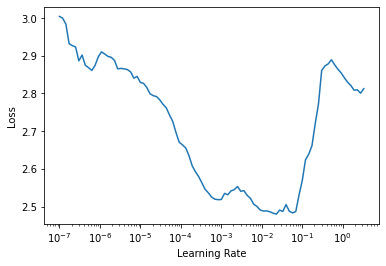

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.801784,2.204889,0.392357,04:38
1,1.451691,2.316245,0.428025,04:41
2,1.280450,1.435784,0.583439,04:39
3,1.152661,2.287817,0.452229,04:41
4,1.040055,1.594737,0.551592,04:40
5,0.952606,1.587954,0.593885,04:39
6,0.805227,0.734746,0.759236,04:40
7,0.708529,0.713946,0.771465,04:41
8,0.608097,0.630813,0.798726,04:40
9,0.558708,0.603449,0.803822,04:39


In [ ]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 112 x 112  864        True      
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 32 x 112 x 112  9,216      True      
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 64 x 112 x 112  18,432     True      
_________________________________________________